In [1]:
from model import fstm_model
from model import dstm_model
from model import create_dstm_data_set
from model import create_tstm_data_set
from util import preprocessing_daegun

df = preprocessing_daegun()

2024-06-07 00:30:57.946803: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 00:30:57.950391: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 00:30:58.026128: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 00:30:59.044442: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df[df['rainfall_train.ef_year'] == 'A']['VV'].describe()

count    485936.000000
mean          1.099673
std           5.172230
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         115.200000
Name: VV, dtype: float64

In [3]:
X,Y,sample_weights,len_list = create_tstm_data_set(df[df['rainfall_train.ef_year'] !='A'])
X_V,Y_V,_,_= create_tstm_data_set(df[df['rainfall_train.ef_year'] == 'A'])

/home/encore/workspace/TSI/model.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['list'] = df.drop(columns=['VV','STN','V0','rainfall_train.ef_year','day','rainfall_train.ef_hour','class','RP']).apply(lambda x: np.array(x),axis=1)
100%|██████████| 20/20 [00:04<00:00,  5.00it/s]
/home/encore/workspace/TSI/model.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['list'] = df.drop(columns=['VV','STN','V0','rainfall_train.ef_year','day','rainfall_train.ef_hour','class','RP']).apply(lambda x: np.a

In [4]:
from tensorflow import keras
timestep=5
input_X = keras.layers.Input((timestep,20,15))
input_Y = keras.layers.Input((timestep,1))
#각 DH 마다의 가중치에 따라 feature 생성
unit = 1
channel_process = []

# 인코딩 과정
for i in range(timestep):
    _channel = keras.layers.Lambda(lambda x : x[:,i,:,:])(input_X)
    _channel = keras.layers.LSTM(100, input_shape=(20,15))(_channel)
    channel_process.append(_channel)
encode_X = keras.layers.Concatenate()(channel_process)
encode_X = keras.layers.Reshape((timestep,100))(encode_X)
encode_X = keras.layers.LSTM(100, return_sequences=True, input_shape=(timestep,))(encode_X)
encode_X = keras.layers.LSTM(50, return_sequences=True, input_shape=(timestep,))(encode_X)
encode_X = keras.layers.LSTM(10, return_sequences=True, input_shape=(timestep,))(encode_X)
encode_out,h,c = keras.layers.LSTM(1, return_sequences=True, return_state=True, input_shape=(timestep,))(encode_X)
# 디코딩 과정
d_h = keras.layers.Reshape((1,))(h[:,-1])
d_c = keras.layers.Reshape((1,))(c[:,-1])
d_o = keras.layers.Reshape((1,1))(encode_out[:,0])
encode_state = [d_h,d_c]
# 비교 (timestep, 10)
DX = keras.layers.Concatenate(axis=1)([d_o,input_Y[:,:-1]])
decoder_lstm = keras.layers.LSTM(unit, return_sequences=True)
DX = decoder_lstm(DX,initial_state=encode_state)
DX = keras.layers.Flatten()(DX)


/home/encore/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
from tensorflow.keras.losses import MeanSquaredError

encode_decode = keras.Model(inputs=[input_X,input_Y], outputs=DX)
encode_decode.compile(optimizer="adam", loss="mean_squared_error")

In [6]:
from metric import CSImetric

checkpoint_cb = keras.callbacks.ModelCheckpoint('tstm_best-model.keras')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                  restore_best_weights=True)
history = encode_decode.fit([X,Y], Y, batch_size=30,validation_data=[[X_V,Y_V],Y_V],epochs=30, verbose=1,callbacks=[checkpoint_cb,early_stopping_cb],sample_weight=sample_weights)

Epoch 1/30


2024-06-07 00:32:40.612661: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 310254000 exceeds 10% of free system memory.


1724/1724 ━━━━━━━━━━━━━━━━━━━━ 134s 70ms/step - loss: 101.7701 - val_loss: 25.2748
Epoch 2/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 120s 70ms/step - loss: 96.3638 - val_loss: 25.2678
Epoch 3/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 156s 78ms/step - loss: 94.8694 - val_loss: 25.2303
Epoch 4/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - loss: 89.7065 - val_loss: 25.1766
Epoch 5/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 152s 84ms/step - loss: 89.3524 - val_loss: 25.1306
Epoch 6/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 133s 77ms/step - loss: 96.8091 - val_loss: 25.1005
Epoch 7/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 131s 76ms/step - loss: 93.5619 - val_loss: 25.0795
Epoch 8/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 154s 89ms/step - loss: 101.6076 - val_loss: 25.0654
Epoch 9/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 164s 95ms/step - loss: 92.8729 - val_loss: 25.0549
Epoch 10/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 166s 96ms/step - loss: 93.9912 - val_loss: 25.0456
Epoch 11/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 141s 82ms/step - loss: 94.3202 - va

In [5]:
encoder= keras.Model(input_X, [encode_out,h,c])

In [6]:
encoder.save_wiegths('encode.keras')

In [8]:
from tensorflow import keras

decode_X = keras.layers.Input((timestep,1))
decode_h = keras.layers.Input((1,))
decode_c = keras.layers.Input((1,))

decodeY = decoder_lstm(decode_X,initial_state=[decode_h,decode_c])
decodeY = keras.layers.Flatten()(decodeY)

decoder = keras.Model([decode_X,decode_h,decode_c],decodeY)

In [9]:
decoder.load_weights('klstm_best-model.keras')

In [10]:
def predict_model(X):
    ex, eh, ec =encoder.predict(X)
    result = decoder.predict([ex,eh,ec])
    return result

In [10]:
from metric import CSImetric

checkpoint_cb = keras.callbacks.ModelCheckpoint('ilstm_best-model.keras')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                  restore_best_weights=True)
history = encode_decode.fit([X,Y], Y, batch_size=30,validation_data=[[X_V,Y_V],Y_V],epochs=30, verbose=1,callbacks=[checkpoint_cb,early_stopping_cb],sample_weight=sample_weights)

Epoch 1/30


2024-06-07 00:27:22.015534: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 310254000 exceeds 10% of free system memory.


1723/1724 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 94.7928

In [33]:
XX=encoder.predict(X_V)

807/807 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step


In [73]:
dx,dh,dc  = encoder2.predict(X)
dxv,dhv,dcv = encoder2.predict(X_V)

   4/1616 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step 

2024-05-30 05:37:55.829819: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 310254000 exceeds 10% of free system memory.


1616/1616 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step
807/807 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step


In [44]:
dh.reshape(-1).shape

(51709,)

In [74]:
decoder.compile(optimizer='adam',loss="mean_squared_error")

In [75]:
from metric import CSImetric

checkpoint_cb = keras.callbacks.ModelCheckpoint('klstm_best-model.keras')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, 
                                                  restore_best_weights=True)
history = decoder.fit([dx,dh,dc], Y, batch_size=30,validation_data=[[dxv,dhv,dcv],Y_V],epochs=30, verbose=1,callbacks=[checkpoint_cb,early_stopping_cb],sample_weight=sample_weights)

Epoch 1/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 5.6173e-10 - val_loss: 5.8659e-11
Epoch 2/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2.5903e-10 - val_loss: 4.2736e-11
Epoch 3/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 1.8460e-10 - val_loss: 1.1104e-10
Epoch 4/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 1.9084e-10 - val_loss: 8.3488e-11
Epoch 5/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 2.2118e-10 - val_loss: 6.1454e-11
Epoch 6/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 1.6736e-10 - val_loss: 3.6494e-11
Epoch 7/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 2.3924e-10 - val_loss: 3.4355e-11
Epoch 8/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 9.9072e-11 - val_loss: 1.6259e-10
Epoch 9/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 2.1126e-10 - val_loss: 3.1364e-11
Epoch 10/30
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 2.2544e-10 - val_loss: 3.0238e-11
Epoch 11/30
1724/1724 ━━━━━━━

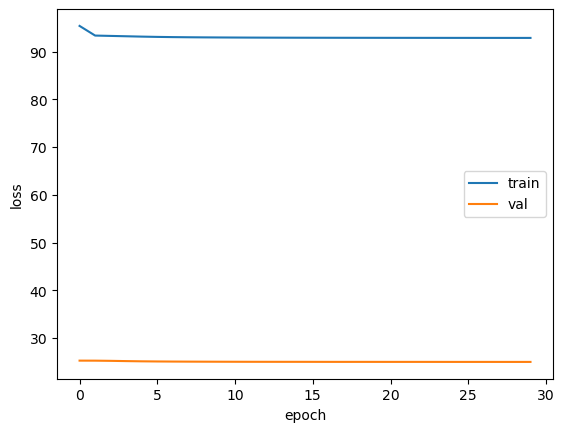

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.savefig('7_3-07', dpi=300)
plt.show()

In [50]:
decoder.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 5, 1)      │         12 │ input_layer_11[0… │
│                     │                   │            │ input_layer_12[0… │
│                     │                   │            │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 5)         │          0 │ lstm_9[4][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38 (156.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26 (108.00 B)

In [ ]:
decoder.save

In [56]:
result =predict_model(X_V)

807/807 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


,DH,VV,STN,V1,V2,V3,V4,V5,V6,V7,...,V0,rainfall_train.ef_hour,rainfall_train.ef_year,day,day_sin,day_cos,hour_sin,hour_cos,RP,BP
0,0.000000,0.0,STN001,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,100,12,A,121,0.002740,0.999996,1.224647e-16,-1.000000e+00,0.000000,1.0
1,0.012658,0.0,STN001,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,100,15,A,121,0.002740,0.999996,-7.071068e-01,-7.071068e-01,0.000000,1.0
2,0.025316,0.0,STN001,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,100,18,A,121,0.002740,0.999996,-1.000000e+00,-1.836970e-16,0.001311,1.0
3,0.037975,0.0,STN001,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,100,21,A,121,0.002740,0.999996,-7.071068e-01,7.071068e-01,0.000000,1.0
4,0.050633,0.0,STN001,0.00,0.00,0.00,0.00,0.00,0.0,0.0,...,100,0,A,122,0.005479,0.999985,0.000000e+00,1.000000e+00,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457247,0.949367,0.5,STN020,0.02,0.05,0.00,0.02,0.00,0.0,0.0,...,91,9,C,283,0.027394,0.999625,7.071068e-01,-7.071068e-01,0.740000,0.0
1457248,0.962025,0.0,STN020,0.04,0.04,0.02,0.02,0.01,0.0,0.0,...,87,12,C,283,0.027394,0.999625,1.224647e-16,-1.000000e+00,0.111667,1.0
1457249,0.974684,1.9,STN020,0.04,0.04,0.02,0.02,0.01,0.0,0.0,...,87,15,C,283,0.027394,0.999625,-7.071068e-01,-7.071068e-01,1.280000,0.0
1457250,0.987342,1.9,STN020,0.02,0.02,0.02,0.00,0.02,0.0,0.0,...,92,18,C,283,0.027394,0.999625,-1.000000e+00,-1.836970e-16,1.198333,0.0


In [61]:
decoder2.load_weights('klstm_best-model.keras')

In [67]:
encoder2= keras.Model(input_X, [encode_out,h,c])

In [68]:
encoder2.load_weights('ilstm_best-model.keras')

In [76]:
def predict_model(X):
    ex, eh, ec =encoder2.predict(X)
    result = decoder2.predict([ex,eh,ec])
    return result

In [77]:
pppy= predict_model(X_V)

807/807 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step
807/807 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


In [78]:
py

array([[-2.18781702e-06,  3.48196704e-06,  5.34205810e-06,
        -5.65851508e-07, -1.24300514e-05],
       [-1.04556398e-06,  5.41348390e-06,  6.67426593e-06,
        -5.00745614e-07, -1.13341830e-05],
       [-5.27254429e-07,  6.65855669e-06,  8.13787210e-06,
         5.06088725e-07, -1.07083633e-05],
       ...,
       [-2.16182571e-06,  1.89612354e-06,  2.27270561e-06,
        -4.29907095e-06, -1.28887059e-05],
       [-9.63613616e-07,  3.82012240e-06,  3.55314842e-06,
        -4.35874335e-06, -1.19599135e-05],
       [-4.15310836e-07,  5.30666921e-06,  5.20773165e-06,
        -3.34726292e-06, -1.15963157e-05]], dtype=float32)

In [79]:
pppy

array([[ 4.8474743e-07,  4.5923207e-06,  6.4919450e-06,  2.4653216e-06,
        -6.3218599e-06],
       [ 1.3526247e-06,  5.9634135e-06,  7.4572467e-06,  2.5887377e-06,
        -5.4748734e-06],
       [ 1.7014052e-06,  6.7868514e-06,  8.3982322e-06,  3.2104294e-06,
        -5.0783792e-06],
       ...,
       [ 5.3412521e-07,  3.5246176e-06,  4.3914974e-06, -1.3593466e-07,
        -6.7811070e-06],
       [ 1.4491757e-06,  4.8919974e-06,  5.3194181e-06, -9.9919461e-08,
        -6.0548668e-06],
       [ 1.8248004e-06,  5.8787150e-06,  6.3928073e-06,  5.3707072e-07,
        -5.8116898e-06]], dtype=float32)

In [80]:
ppy

array([[ 7.1550771e-06,  1.5108981e-05,  1.8321263e-05,  1.2440106e-05,
        -4.3109148e-07],
       [ 8.3874829e-06,  1.7101755e-05,  1.9708219e-05,  1.2590979e-05,
         8.0877777e-07],
       [ 8.8993038e-06,  1.8309296e-05,  2.1077516e-05,  1.3483041e-05,
         1.3737941e-06],
       ...,
       [ 7.1726708e-06,  1.3516524e-05,  1.5238676e-05,  8.6498530e-06,
        -1.0385992e-06],
       [ 8.4609046e-06,  1.5499147e-05,  1.6569293e-05,  8.6721711e-06,
         2.5011165e-08],
       [ 9.0071817e-06,  1.6945853e-05,  1.8130007e-05,  9.5828345e-06,
         3.6222730e-07]], dtype=float32)

In [65]:
result

array([[-2.18781702e-06,  3.48196704e-06,  5.34205810e-06,
        -5.65851508e-07, -1.24300514e-05],
       [-1.04556398e-06,  5.41348390e-06,  6.67426593e-06,
        -5.00745614e-07, -1.13341830e-05],
       [-5.27254429e-07,  6.65855669e-06,  8.13787210e-06,
         5.06088725e-07, -1.07083633e-05],
       ...,
       [-2.16182571e-06,  1.89612354e-06,  2.27270561e-06,
        -4.29907095e-06, -1.28887059e-05],
       [-9.63613616e-07,  3.82012240e-06,  3.55314842e-06,
        -4.35874335e-06, -1.19599135e-05],
       [-4.15310836e-07,  5.30666921e-06,  5.20773165e-06,
        -3.34726292e-06, -1.15963157e-05]], dtype=float32)

In [70]:
ppy  = predict_model(X_V)

807/807 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step
807/807 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


In [71]:
ppy

array([[ 7.1550771e-06,  1.5108981e-05,  1.8321263e-05,  1.2440106e-05,
        -4.3109148e-07],
       [ 8.3874829e-06,  1.7101755e-05,  1.9708219e-05,  1.2590979e-05,
         8.0877777e-07],
       [ 8.8993038e-06,  1.8309296e-05,  2.1077516e-05,  1.3483041e-05,
         1.3737941e-06],
       ...,
       [ 7.1726708e-06,  1.3516524e-05,  1.5238676e-05,  8.6498530e-06,
        -1.0385992e-06],
       [ 8.4609046e-06,  1.5499147e-05,  1.6569293e-05,  8.6721711e-06,
         2.5011165e-08],
       [ 9.0071817e-06,  1.6945853e-05,  1.8130007e-05,  9.5828345e-06,
         3.6222730e-07]], dtype=float32)

In [72]:
py

array([[-2.18781702e-06,  3.48196704e-06,  5.34205810e-06,
        -5.65851508e-07, -1.24300514e-05],
       [-1.04556398e-06,  5.41348390e-06,  6.67426593e-06,
        -5.00745614e-07, -1.13341830e-05],
       [-5.27254429e-07,  6.65855669e-06,  8.13787210e-06,
         5.06088725e-07, -1.07083633e-05],
       ...,
       [-2.16182571e-06,  1.89612354e-06,  2.27270561e-06,
        -4.29907095e-06, -1.28887059e-05],
       [-9.63613616e-07,  3.82012240e-06,  3.55314842e-06,
        -4.35874335e-06, -1.19599135e-05],
       [-4.15310836e-07,  5.30666921e-06,  5.20773165e-06,
        -3.34726292e-06, -1.15963157e-05]], dtype=float32)